In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import dask
import os

In [2]:
#load in hfls data and also laod in lhf era5 data
e5_LH = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_lhf.nc")
e5_SH = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_shf.nc")
e5_SW = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_swrf.nc")
e5_LW = xr.open_dataarray("/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_lwrf.nc")       

In [3]:
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'#dict with file names


In [4]:
models={}
varis = {'lw':'_netLW.nc', 'sw':'_netSW.nc', 'lhf':'_hfls.nc', 'shf':'_hfss.nc', 'qnet':'_qnet.nc'}
for model in os.listdir(datadir):
    #go thorugh all varis
    if model in ['NESM3']:
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
                models[model] = mod

            except Exception as e:
                print(e)
                pass



[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netLW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netSW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfls.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfss.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_qnet.nc'


In [5]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [6]:
for i, model in enumerate(models.keys()):
    model_hf=models[model]
    lw=model_hf['lw'].assign_coords({'model':model})
    sw=model_hf['sw'].assign_coords({'model':model})
    sh=model_hf['shf'].assign_coords({'model':model})
    lh=model_hf['lhf'].assign_coords({'model':model})
    q=(lw+sw-lh-sh)#terms are all positive so have to add in sign, and scale to degC/month

    if i == 0:
        lwm = lw
        swm = sw
        shm = sh
        lhm = lh
        qm = q
    else:
        lwm = xr.concat([lwm, lw], dim = 'model')
        swm = xr.concat([swm, sw], dim = 'model')
        shm = xr.concat([shm, sh], dim = 'model')
        lhm = xr.concat([lhm, lh], dim = 'model')
        qm = xr.concat([qm, q], dim = 'model')
        


In [7]:
def IQR_plot(vari,d, lat, lat1, lon, lon1):
    V, label = var_titles[vari]
    axs[d].fill_between(range(1,13), get_region(((V.quantile(0.25, 'model'))),  lat, lat1, lon, lon1),
                      get_region(((V.quantile(0.75, 'model'))),  lat, lat1, lon, lon1), 
                      alpha = 0.25)
    return

def median_plt(vari,d, lat, lat1, lon, lon1):
    V, label = var_titles[vari]
    axs[d].plot(range(1,13), get_region(V.median('model'), lat, lat1, lon, lon1), label = label)
    return

def obs_plt(vari,d, lat, lat1, lon, lon1):
    V, label, col = var_titles[vari]
    axs[d].plot(range(1,13), get_region(V, lat, lat1, lon, lon1), label = label, ls = '--', c = col)
    return

def plt_HF_reg(lat, lat1, lon, lon1):
    plt.figure(figsize = (10,16))
    get_region(lwm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Longwave')
    IQR_plot(lwm, lat, lat1, lon, lon1)
    get_region(swm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Shortwave')
    IQR_plot(swm, lat, lat1, lon, lon1)
    get_region(-1*shm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Sensible')
    IQR_plot(-1*shm, lat, lat1, lon, lon1)
    get_region(-1*lhm, lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Latent')
    IQR_plot(-1*lhm, lat, lat1, lon, lon1)
    get_region((lwm+swm -shm -lhm), lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Qnet')
    IQR_plot((lwm+swm -shm -lhm), lat, lat1, lon, lon1)
    #get_region((qm), lat, lat1, lon, lon1).median('model').plot(label = 'CMIP6 MMM Qnet')
    
    
    
    get_region(e5_LW, lat, lat1, lon, lon1).plot(label = 'ERA5 Longwave', c = 'tab:blue', ls = '--')
    get_region(e5_SW, lat, lat1, lon, lon1).plot(label = 'ERA5 Shortwave', c= 'tab:orange', ls = '--')
    get_region(e5_SH, lat, lat1, lon, lon1).plot(label = 'ERA5 Sensible', c = 'tab:green', ls = '--')
    get_region(e5_LH, lat, lat1, lon, lon1).plot(label = 'ERA5 Latent', c= 'tab:red', ls = '--')
    get_region((e5_LW+e5_SW +e5_SH +e5_LH), lat, lat1, lon, lon1).plot(label = 'ERA5 Qnet', c= 'tab:purple', ls = '--')

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    return

In [8]:
var_titles={'LW':[lwm,'CMIP6 MMM Longwave'], 'SW':[swm, 'CMIP6 MMM Shortwave'], 'SH':[-1*shm, 'CMIP6 MMM Sensible heat'], 
            'LH':[-1*lhm, 'CMIP6 MMM Latent heat'], 'Q':[(lwm+swm -shm -lhm), 'CMIP6 MMM Qnet'],
           'eLW':[e5_LW,'ERA5 Longwave', 'tab:blue'], 'eSW':[e5_SW, 'ERA5 Shortwave', 'tab:orange'],
            'eSH':[e5_SH, 'ERA5 Sensible heat', 'tab:red'], 
            'eLH':[e5_LH, 'ERA5 Latent heat', 'tab:green'], 'eQ':[(e5_LW+e5_SW +e5_SH +e5_LH), 'ERA5 Qnet', 'tab:purple']}


In [9]:
regions = {'WTIO':('a)', -10,10,50,70), 'SETIO':('b)',-10,0,90,110),'Arabian Sea':('c)',10,20,50,70)}#, 'BOB': ('d', 10,20,80,100)}

/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/na

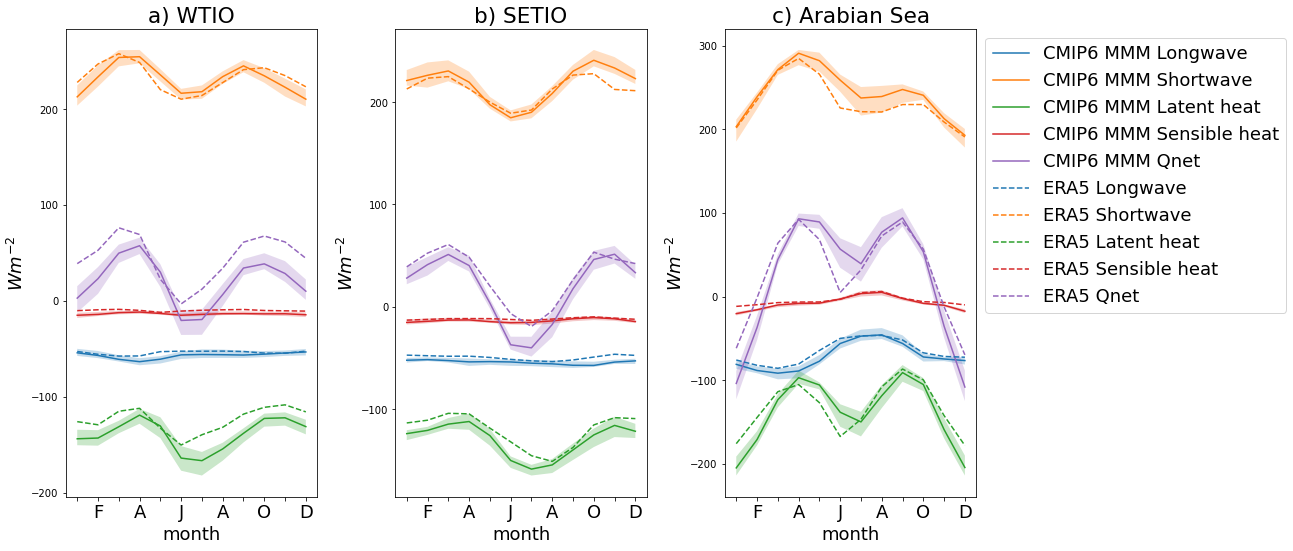

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))
plt.rcParams['font.size'] = 18
axs = axs.ravel()
for i, reg in enumerate(regions.items()):
    lat = reg[1][1]
    lat1 = reg[1][2]
    lon = reg[1][3]
    lon1 = reg[1][4]
    median_plt('LW',i, lat,lat1,lon,lon1)
    IQR_plot('LW', i,  lat,lat1,lon,lon1)
    median_plt('SW',i, lat,lat1,lon,lon1)
    IQR_plot('SW', i,  lat,lat1,lon,lon1)
    median_plt('LH',i, lat,lat1,lon,lon1)
    IQR_plot('LH', i,  lat,lat1,lon,lon1)
    median_plt('SH',i, lat,lat1,lon,lon1)
    IQR_plot('SH', i,  lat,lat1,lon,lon1)
    median_plt('Q',i, lat,lat1,lon,lon1)
    IQR_plot('Q', i,  lat,lat1,lon,lon1)
    #now plot Obs
    obs_plt('eLW',i, lat,lat1,lon,lon1)
    obs_plt('eSW',i, lat,lat1,lon,lon1)
    obs_plt('eLH',i, lat,lat1,lon,lon1)
    obs_plt('eSH',i, lat,lat1,lon,lon1)
    obs_plt('eQ',i, lat,lat1,lon,lon1)
    axs[i].set_title(reg[1][0]+' '+reg[0])
    axs[i].set_xlabel('month',fontsize=18)
    axs[i].set_ylabel("$Wm^{-2}$", fontsize=18)
    #axs[i].set_xticks([2,4,6,8,10,12]) 
    #axs[i].set_xticklabels(['F', 'A', 'J','A','O','D'], fontsize=14)
    axs[i].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])#, ['F', 'A', 'J','A','O','D'])
    axs[i].set_xticklabels( [' ', 'F',' ',  'A',' ', 'J',' ', 'A',' ', 'O',' ', 'D'], fontsize=18)
    plt.tight_layout()
# Create the legend|
plt.legend( bbox_to_anchor=(1, 1), loc='upper left')
